# 03 - Model Training: Crop Disease Classification with MobileNetV2

## Goals of this Notebook

- Set up training and validation pipelines
- Fine-tune a pretrained MobileNetV2 model
- Use light data augmentation on training images
- Track model performance during training
- Save the best performing model for downstream use

---

## Why Fine-Tuning?

Instead of training from scratch (which requires huge datasets and resources),  
we leverage MobileNetV2's pretrained knowledge of general textures, shapes, and colors.  
We only retrain its final classifier to specialize in detecting crop diseases from leaves.

---

In [5]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

current_dir = os.getcwd()
print(f"[DEBUG] Current working directory: {current_dir}")

project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"[DEBUG] Project root added to sys.path: {project_root}")

from src.data.dataset import PlantVillageDataset
from src.data.augment import AugmentationPipeline
from src.model.architecture import build_model
from src.model.train import train_one_epoch, validate_one_epoch
from src.utils.config import TRAIN_DIR, VAL_DIR, MODEL_DIR, BEST_MODEL_PATH

# 📦 Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[DEBUG] Current working directory: /Users/mitra/vibe_code/CropGuard/notebooks
[DEBUG] Project root added to sys.path: /Users/mitra/vibe_code/CropGuard
[INFO] Using device: cpu


# STEP 1: Building Training and Validation Datasets

We will use:

- **Train Transformations** ➔ flip, rotate, jitter, normalize
- **Val Transformations** ➔ only normalize (no augmentation)

Then wrap them into DataLoaders for batching and shuffling.

In [7]:
# Set up transforms
augment = AugmentationPipeline()

train_ds = PlantVillageDataset(
    root_dir=TRAIN_DIR,
    transform=augment.get_transforms("train")
)

val_ds = PlantVillageDataset(
    root_dir=VAL_DIR,
    transform=augment.get_transforms("val")
)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

dataloaders = {"train": train_loader, "val": val_loader}

# STEP 2: Model, Loss Function, Optimizer and Learning Rate Scheduler

- **Model:** MobileNetV2 pretrained on ImageNet
- **Loss:** CrossEntropyLoss (standard for multi-class classification)
- **Optimizer:** Adam (adaptive learning rate optimizer)
- **Scheduler:** ReduceLROnPlateau (lower learning rate when val loss plateaus)

In [6]:
# Number of classes
num_classes = len(train_ds.class_to_idx)

# Build model
model = build_model(num_classes=num_classes, freeze_backbone=True)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Scheduler: reduce LR when val loss stops improving
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# STEP 3: Training and Validation

Train the model for a number of epochs,  
track training and validation loss and accuracy,  
and save the best model checkpoint based on validation accuracy.

In [8]:
from tqdm import tqdm
import time

num_epochs = 20
best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

os.makedirs(MODEL_DIR, exist_ok=True)

for epoch in range(num_epochs):
    start_time = time.time()
    print(f"\n🟰🟰🟰 [INFO] Starting Epoch {epoch+1}/{num_epochs} 🟰🟰🟰")

    # Training phase
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    train_loader = tqdm(dataloaders["train"], desc=f"Epoch {epoch+1} - Training", leave=False)

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_total += labels.size(0)

        train_loader.set_postfix({
            'loss': loss.item(),
            'acc': train_correct / train_total
        })

    train_loss = train_running_loss / len(dataloaders["train"])
    train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    val_loader = tqdm(dataloaders["val"], desc=f"Epoch {epoch+1} - Validation", leave=False)

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

            val_loader.set_postfix({
                'loss': loss.item(),
                'acc': val_correct / val_total
            })

    val_loss = val_running_loss / len(dataloaders["val"])
    val_acc = val_correct / val_total

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    epoch_duration = time.time() - start_time
    print(f"[INFO] Epoch {epoch+1} completed in {epoch_duration:.2f} sec")
    print(f"  - Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  - Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f" Best model saved with Val Acc: {best_val_acc:.4f}")


🟰🟰🟰 [INFO] Starting Epoch 1/20 🟰🟰🟰


[INFO] Epoch 1 completed in 744.88 sec
  - Train Loss: 0.8718 | Train Acc: 0.7567
  - Val Loss: 0.4158 | Val Acc: 0.8802
[💾] Best model saved with Val Acc: 0.8802

🟰🟰🟰 [INFO] Starting Epoch 2/20 🟰🟰🟰


[INFO] Epoch 2 completed in 745.61 sec
  - Train Loss: 0.4721 | Train Acc: 0.8544
  - Val Loss: 0.3075 | Val Acc: 0.9052
[💾] Best model saved with Val Acc: 0.9052

🟰🟰🟰 [INFO] Starting Epoch 3/20 🟰🟰🟰


[INFO] Epoch 3 completed in 760.69 sec
  - Train Loss: 0.4150 | Train Acc: 0.8646
  - Val Loss: 0.2766 | Val Acc: 0.9129
[💾] Best model saved with Val Acc: 0.9129

🟰🟰🟰 [INFO] Starting Epoch 4/20 🟰🟰🟰


[INFO] Epoch 4 completed in 772.69 sec
  - Train Loss: 0.3880 | Train Acc: 0.8737
  - Val Loss: 0.2534 | Val Acc: 0.9200
[💾] Best model saved with Val Acc: 0.9200

🟰🟰🟰 [INFO] Starting Epoch 5/20 🟰🟰🟰


[INFO] Epoch 5 completed in 755.48 sec
  - Train Loss: 0.3736 | Train Acc: 0.8764
  - Val Loss: 0.2733 | Val Acc: 0.9065

🟰🟰🟰 [INFO] Starting Epoch 6/20 🟰🟰🟰


[INFO] Epoch 6 completed in 745.81 sec
  - Train Loss: 0.3697 | Train Acc: 0.8743
  - Val Loss: 0.2454 | Val Acc: 0.9203
[💾] Best model saved with Val Acc: 0.9203

🟰🟰🟰 [INFO] Starting Epoch 7/20 🟰🟰🟰


[INFO] Epoch 7 completed in 1655.25 sec
  - Train Loss: 0.3625 | Train Acc: 0.8788
  - Val Loss: 0.2885 | Val Acc: 0.9076

🟰🟰🟰 [INFO] Starting Epoch 8/20 🟰🟰🟰


[INFO] Epoch 8 completed in 924.65 sec
  - Train Loss: 0.3545 | Train Acc: 0.8820
  - Val Loss: 0.2433 | Val Acc: 0.9213
[💾] Best model saved with Val Acc: 0.9213

🟰🟰🟰 [INFO] Starting Epoch 9/20 🟰🟰🟰


[INFO] Epoch 9 completed in 1852.09 sec
  - Train Loss: 0.3523 | Train Acc: 0.8817
  - Val Loss: 0.2562 | Val Acc: 0.9153

🟰🟰🟰 [INFO] Starting Epoch 10/20 🟰🟰🟰


[INFO] Epoch 10 completed in 1355.58 sec
  - Train Loss: 0.3542 | Train Acc: 0.8789
  - Val Loss: 0.2294 | Val Acc: 0.9244
[💾] Best model saved with Val Acc: 0.9244

🟰🟰🟰 [INFO] Starting Epoch 11/20 🟰🟰🟰


[INFO] Epoch 11 completed in 2242.25 sec
  - Train Loss: 0.3463 | Train Acc: 0.8857
  - Val Loss: 0.2090 | Val Acc: 0.9315
[💾] Best model saved with Val Acc: 0.9315

🟰🟰🟰 [INFO] Starting Epoch 12/20 🟰🟰🟰


[INFO] Epoch 12 completed in 3352.88 sec
  - Train Loss: 0.3409 | Train Acc: 0.8832
  - Val Loss: 0.2296 | Val Acc: 0.9230

🟰🟰🟰 [INFO] Starting Epoch 13/20 🟰🟰🟰


[INFO] Epoch 13 completed in 755.69 sec
  - Train Loss: 0.3408 | Train Acc: 0.8834
  - Val Loss: 0.2430 | Val Acc: 0.9170

🟰🟰🟰 [INFO] Starting Epoch 14/20 🟰🟰🟰


[INFO] Epoch 14 completed in 744.68 sec
  - Train Loss: 0.3440 | Train Acc: 0.8839
  - Val Loss: 0.2215 | Val Acc: 0.9257

🟰🟰🟰 [INFO] Starting Epoch 15/20 🟰🟰🟰


[INFO] Epoch 15 completed in 3724.28 sec
  - Train Loss: 0.3357 | Train Acc: 0.8877
  - Val Loss: 0.2069 | Val Acc: 0.9304

🟰🟰🟰 [INFO] Starting Epoch 16/20 🟰🟰🟰


[INFO] Epoch 16 completed in 2252.74 sec
  - Train Loss: 0.3469 | Train Acc: 0.8833
  - Val Loss: 0.2335 | Val Acc: 0.9203

🟰🟰🟰 [INFO] Starting Epoch 17/20 🟰🟰🟰


[INFO] Epoch 17 completed in 967.55 sec
  - Train Loss: 0.3410 | Train Acc: 0.8851
  - Val Loss: 0.2409 | Val Acc: 0.9208

🟰🟰🟰 [INFO] Starting Epoch 18/20 🟰🟰🟰


[INFO] Epoch 18 completed in 7587.58 sec
  - Train Loss: 0.3383 | Train Acc: 0.8880
  - Val Loss: 0.2106 | Val Acc: 0.9329
[💾] Best model saved with Val Acc: 0.9329

🟰🟰🟰 [INFO] Starting Epoch 19/20 🟰🟰🟰


[INFO] Epoch 19 completed in 801.89 sec
  - Train Loss: 0.3345 | Train Acc: 0.8891
  - Val Loss: 0.2239 | Val Acc: 0.9277

🟰🟰🟰 [INFO] Starting Epoch 20/20 🟰🟰🟰


[INFO] Epoch 20 completed in 1004.97 sec
  - Train Loss: 0.3164 | Train Acc: 0.8949
  - Val Loss: 0.1948 | Val Acc: 0.9334
[💾] Best model saved with Val Acc: 0.9334


# STEP 4: Plotting Loss and Accuracy Curves

Visualizing training progress helps diagnose overfitting, underfitting, or training issues early.

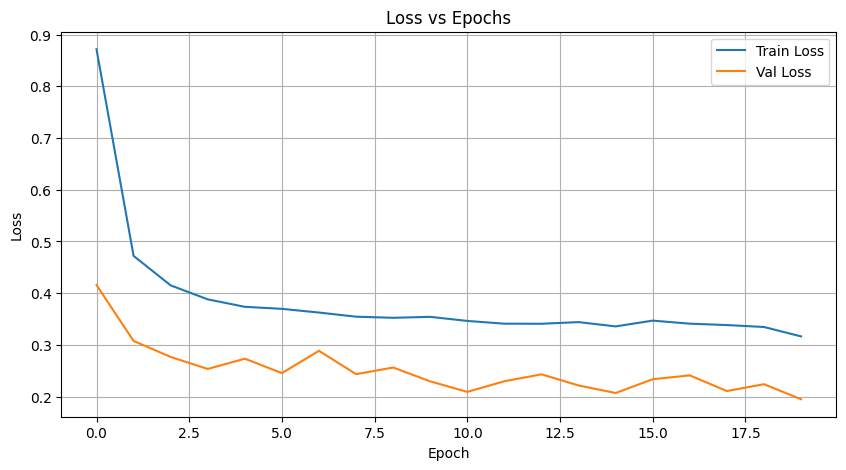

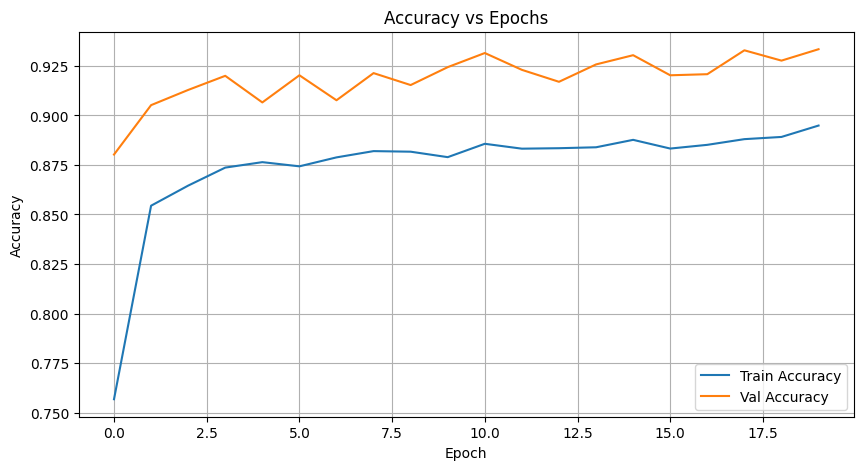

In [10]:
# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# STEP 5: Saving Model and Wrapping Up

- The best model (highest validation accuracy) has been saved at:
  - `models/cropguard_best.pt`
- Ready for inference or deployment in app!

---

MobileNetV2 fine-tuning completed successfully.  
Next step: Evaluate on Test set and/or integrate into app.

---

# STEP 6: Save Model Labels

In [9]:
import json
import os

# Assuming you have a class_to_idx dict from your training dataset
# If not, create from train_ds directly
class_to_idx = train_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Make sure the model directory exists
os.makedirs("models", exist_ok=True)

# Save the mapping
with open("models/labels.json", "w") as f:
    json.dump(idx_to_class, f, indent=4)

print("[INFO] Saved labels.json successfully.")

[INFO] Saved labels.json successfully.
